### Daytum Course: Spatial Data Analytics

### Bootstrap for Subsurface Data Analytics in Python 

Here's a simple workflow, demonstration of bootstrap for subsurface modeling workflows. This should help you get started with building subsurface models that integrate uncertainty in the sample statistics.  

#### Bootstrap

Uncertainty in the sample statistics
* one source of uncertainty is the paucity of data.
* do 200 or even less wells provide a precise (and accurate estimate) of the mean? standard deviation? skew? P13?

Would it be useful to know the uncertainty in these statistics due to limited sampling?
* what is the impact of uncertainty in the mean porosity e.g. 20%+/-2%?

**Bootstrap** is a method to assess the uncertainty in a sample statistic by repeated random sampling with replacement.

Assumptions
* sufficient, representative sampling, identical, idependent samples

Limitations
1. assumes the samples are representative 
2. assumes stationarity
3. only accounts for uncertainty due to too few samples, e.g. no uncertainty due to changes away from data
4. does not account for boundary of area of interest 
5. assumes the samples are independent
6. does not account for other local information sources

The **Bootstrap Approach** (Efron, 1982)

Statistical resampling procedure to calculate uncertainty in a calculated statistic from the data itself.
* Does this work?  Prove it to yourself, for uncertainty in the mean solution is standard error: 

\begin{equation}
\sigma^2_{\overline{x}} = \frac{\sigma^2_s}{n}
\end{equation}

Extremely powerful - could calculate uncertainty in any statistic!  e.g. P13, skew etc.
* Would not be possible access general uncertainty in any statistic without bootstrap.
* Advanced forms account for spatial information and sampling strategy (game theory and Journel’s spatial bootstrap (1993).

Steps: 

1. assemble a sample set, must be representative, reasonable to assume independence between samples

2. optional: build a cumulative distribution function (CDF)
    * may account for declustering weights, tail extrapolation
    * could use analogous data to support

3. For $\ell = 1, \ldots, L$ realizations, do the following:

    * For $i = \alpha, \ldots, n$ data, do the following:

        * Draw a random sample with replacement from the sample set or Monte Carlo simulate from the CDF (if available). 

6. Calculate a realization of the sammary statistic of interest from the $n$ samples, e.g. $m^\ell$, $\sigma^2_{\ell}$. Return to 3 for another realization.

7. Compile and summarize the $L$ realizations of the statistic of interest.

This is a very powerful method.  Let's try it out.

#### Objective 

In the PGE 383: Stochastic Subsurface Modeling class I want to provide hands-on experience with building subsurface modeling workflows. Python provides an excellent vehicle to accomplish this. I have coded a package called GeostatsPy with GSLIB: Geostatistical Library (Deutsch and Journel, 1998) functionality that provides basic building blocks for building subsurface modeling workflows. 

The objective is to remove the hurdles of subsurface modeling workflow construction by providing building blocks and sufficient examples. This is not a coding class per se, but we need the ability to 'script' workflows working with numerical methods.    

#### Load the required libraries

The following code loads the required libraries.

In [1]:
import geostatspy.GSLIB as GSLIB          # GSLIB utilies, visualization and wrapper
import geostatspy.geostats as geostats    # GSLIB methods convert to Python        

We will also need some standard packages. These should have been installed with Anaconda 3.

In [2]:
import numpy as np                        # ndarrys for gridded data
import pandas as pd                       # DataFrames for tabular data
import os                                 # set working directory, run executables
import matplotlib.pyplot as plt           # for plotting
import seaborn as sns                     # advanced statistical methods and plots
from scipy import stats                   # summary statistics
import math                               # trig etc.
import scipy.signal as signal             # kernel for moving window calculation
import random
import warnings
warnings.filterwarnings('ignore')

#### Loading Tabular Data

Here's the command to load our comma delimited data file in to a Pandas' DataFrame object.  

In [4]:
#df = pd.read_csv('sample_data_biased.csv') # load our data table
df = pd.read_csv('https://raw.githubusercontent.com/GeostatsGuy/GeoDataSets/master/sample_data_biased.csv')

Let's drop some samples so that we increase the variations in bootstrap samples for our demonstration below.  

* We will resample 25% of the original data file.  

* I use a random number seed so that we all get the same sample to work with.  

```python 
df.sample(frac = 0.25, random_state = 73073)
```

where *frac* is the fraction to select and *random_state* is the random number seed.

To get different random 25% subset of the data, just drop the 'rand_state' parameter or change the value from '73073' to any other integer.

In [5]:
df = df.sample(frac = 0.25, random_state = 73073) # extract 25% random samples to reduce the size of the dataset   
print('Using ' + str(len(df)) + ' number of samples')

Using 72 number of samples


Visualizing the DataFrame would be useful and we already learned about these methods in this demo (https://git.io/fNgRW). 

We can preview the DataFrame by printing a slice or by utilizing the 'head' DataFrame member function (with a nice and clean format, see below). With the slice we could look at any subset of the data table and with the head command, add parameter 'n=13' to see the first 13 rows of the dataset.  

In [6]:
print(df.iloc[0:5,:])                   # display first 4 samples in the table as a preview
df.head(n=13)                           # we could also use this command for a table preview

       X    Y  Facies  Porosity         Perm
150   20   69       0  0.104484     3.003225
17   400  600       1  0.163054   317.883581
68   640  529       1  0.120547    10.801778
234  490  289       1  0.144525    16.251107
214  470  899       1  0.211944  1302.937858


,X,Y,Facies,Porosity,Perm
150,20,69,0,0.104484,3.003225
17,400,600,1,0.163054,317.883581
68,640,529,1,0.120547,10.801778
234,490,289,1,0.144525,16.251107
214,470,899,1,0.211944,1302.937858
153,360,279,1,0.134607,9.776276
5,200,800,1,0.154648,106.491795
170,670,889,1,0.119601,17.052309
252,200,359,0,0.077625,0.540486
131,320,99,1,0.141749,13.154686


#### Summary Statistics for Tabular Data

The table includes X and Y coordinates (meters), Facies 1 and 0 (1 is sandstone and 0 interbedded sand and mudstone), Porosity (fraction), and permeability as Perm (mDarcy). 

There are a lot of efficient methods to calculate summary statistics from tabular data in DataFrames. The describe command provides count, mean, minimum, maximum, and quartiles all in a nice data table. We use transpose just to flip the table so that features are on the rows and the statistics are on the columns.

In [7]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
X,72.0,448.611111,239.825674,0.000000,295.000000,415.000000,640.000000,990.000000
Y,72.0,495.111111,293.106026,39.000000,279.000000,494.000000,716.750000,999.000000
Facies,72.0,0.833333,0.375293,0.000000,1.000000,1.000000,1.000000,1.000000
Porosity,72.0,0.135360,0.039304,0.074349,0.106374,0.124065,0.147035,0.223661
Perm,72.0,242.573614,553.551806,0.093252,2.979039,13.509371,51.052217,2372.383732


#### Visualizing Tabular Data with Location Maps 

It is natural to set the x and y coordinate and feature ranges manually. e.g. do you want your color bar to go from 0.05887 to 0.24230 exactly? Also, let's pick a color map for display. 

* I heard that plasma is known to be friendly to the color blind as the color and intensity vary together (hope I got that right, it was an interesting Twitter conversation started by Matt Hall from Agile if I recall correctly). 

We will assume a study area of 0 to 1,000m in x and y and omit any data outside this area.

In [8]:
xmin = 0.0; xmax = 1000.0               # range of x values
ymin = 0.0; ymax = 1000.0               # range of y values
pormin = 0.05; pormax = 0.25;           # range of porosity values
nx = 100; ny = 100; csize = 10.0
cmap = plt.cm.plasma                    # color map

Let's try out locmap. This is a reimplementation of GSLIB's locmap program that uses matplotlib. I hope you find it simpler than matplotlib.

* If you want to get more advanced and build custom plots lock at the source. 

If you improve it, send me the new code. Any help is appreciated. 

* To see the parameters, just type the command name:

In [9]:
GSLIB.locmap

<function geostatspy.GSLIB.locmap(df, xcol, ycol, vcol, xmin, xmax, ymin, ymax, vmin, vmax, title, xlabel, ylabel, vlabel, cmap, fig_name)>

Now we can populate the plotting parameters and visualize the porosity data.

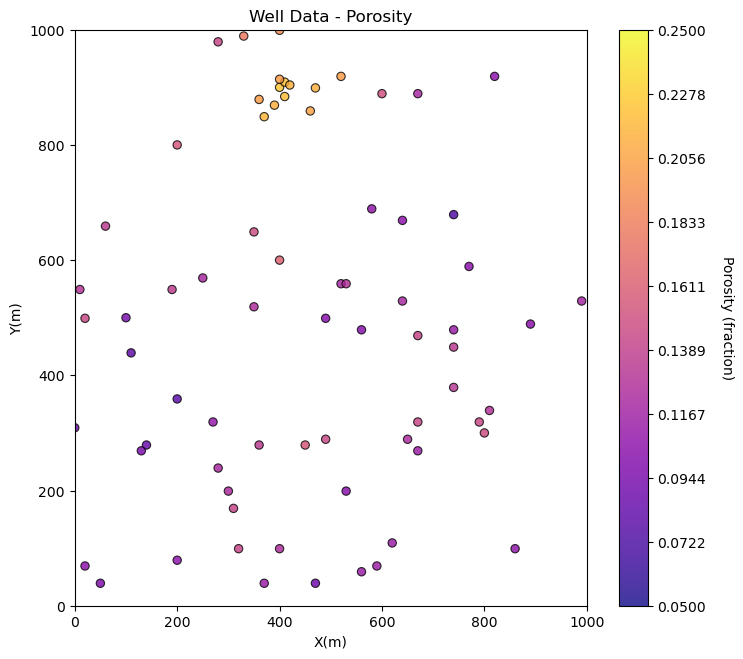

In [10]:
plt.subplot(111)
GSLIB.locmap_st(df,'X','Y','Porosity',xmin,xmax,ymin,ymax,pormin,pormax,'Well Data - Porosity','X(m)','Y(m)','Porosity (fraction)',cmap)
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.2, wspace=0.2, hspace=0.2)
plt.show()

#### Debiasing the Spatial Dataset

We must mitigate bias in the spatial sampling.

* If the samples are biased, then any resulting uncertainty model in a statistic may be biased.

* Cell-based declustering is a common method for debiasing spatial data.

Let's calculate some declustering weights. There is a demonstration on declustering here https://git.io/fhgJl if you need more information. 

* I have coded cell based declustering from GSLIB in the GeostatsPy package.

In [11]:
wts, cell_sizes, dmeans = geostats.declus(df,'X','Y','Porosity',iminmax = 1, noff= 10, ncell=100,cmin=10,cmax=2000)
df['Wts'] = wts                           # add weights to the sample data DataFrame
df.head()                                 # preview to check the sample data DataFrame

def weighted_avg_and_std(values, weights): # function to calculate weighted mean and st. dev., from Eric O Lebigot, stack overflow,
    average = np.average(values, weights=weights)
    variance = np.average((values-average)**2, weights=weights)
    return (average, math.sqrt(variance))

sample_avg, sample_stdev = weighted_avg_and_std(df['Porosity'],df['Wts'])
print('Declustered mean = ' + str(round(sample_avg,3)) + ' and declustered standard deviation = ' + str(round(sample_stdev,3)))

There are 72 data with:
   mean of      0.13535995545833332 
   min and max  0.074348923 and 0.223660709
   standard dev 0.03902973923480811 


100%|██████████| 101/101 [00:00<00:00, 716.62it/s]

Declustered mean = 0.126 and declustered standard deviation = 0.032


##### A Couple of Bootstrap Realizations

We will attempt boostrap by-hand and manually loop over $L$ realizations and draw $n$ samples to calculate the summary statistics of interest, mean and variance. The choice function from the random package simplifies sampling with replacement from a set of samples with weights.

This command returns a ndarray with k samples with replacment from the 'Porosity' column of our DataFrame (df) accounting for the data weights in column 'Wts'.
```p
samples1 = random.choices(df['Porosity'].values, weights=df['Wts'].values, cum_weights=None, k=len(df))
```

It is instructive to look at a few of these realizations from the original declustered data set.

**CodingTips** - To understand this code below there are just a couple of Python concepts that you need to add to your Python arsenal.

1. declaring arrays - NumPy has a lot of great array (ndarray) functionality. There are build in functions to make a ndarray of any length (and dimension). This includes 'zeros', 'ones' and 'rand', so when we use this code: 

 `samples = np.zeros((nreal,len(df))` 
 
 we're making a 2D array of size number of realizations, nreal, x number of data in the DataFrame, df, pre-populated with zeros.  Note the len(df) command returns the number of samples in the DataFrame. 


2. For Loops - when we are using the command below, we are instructing the computer to loop over all the indented code below the command for $ireal = 0,1,2,\ldots,nreal-1$ times. For each loop the $ireal$ variable increments, so we can use this to save each result to a different index in the arrays mean and stdev. Note, Python arrays index starting at 0 and stop at the length - 1.

 `for ireal in range(0,nreal):`

 we are running each bootstrap resampled realization, and storing each realization in a row of the 2D array (for a 2D array the first index is the row index and the second index is the column index).
 
    
3. Subplots - we can put multple plots together with subplots.  To do this we specify

 `plt.subplot(3,3,1)`

 before each plot.  Where the first value is the number of row, the second number is the number of columns and the third number is the image index from $0,...,nrow x ncol$.  The images sort from left to right and then from top to bottom.

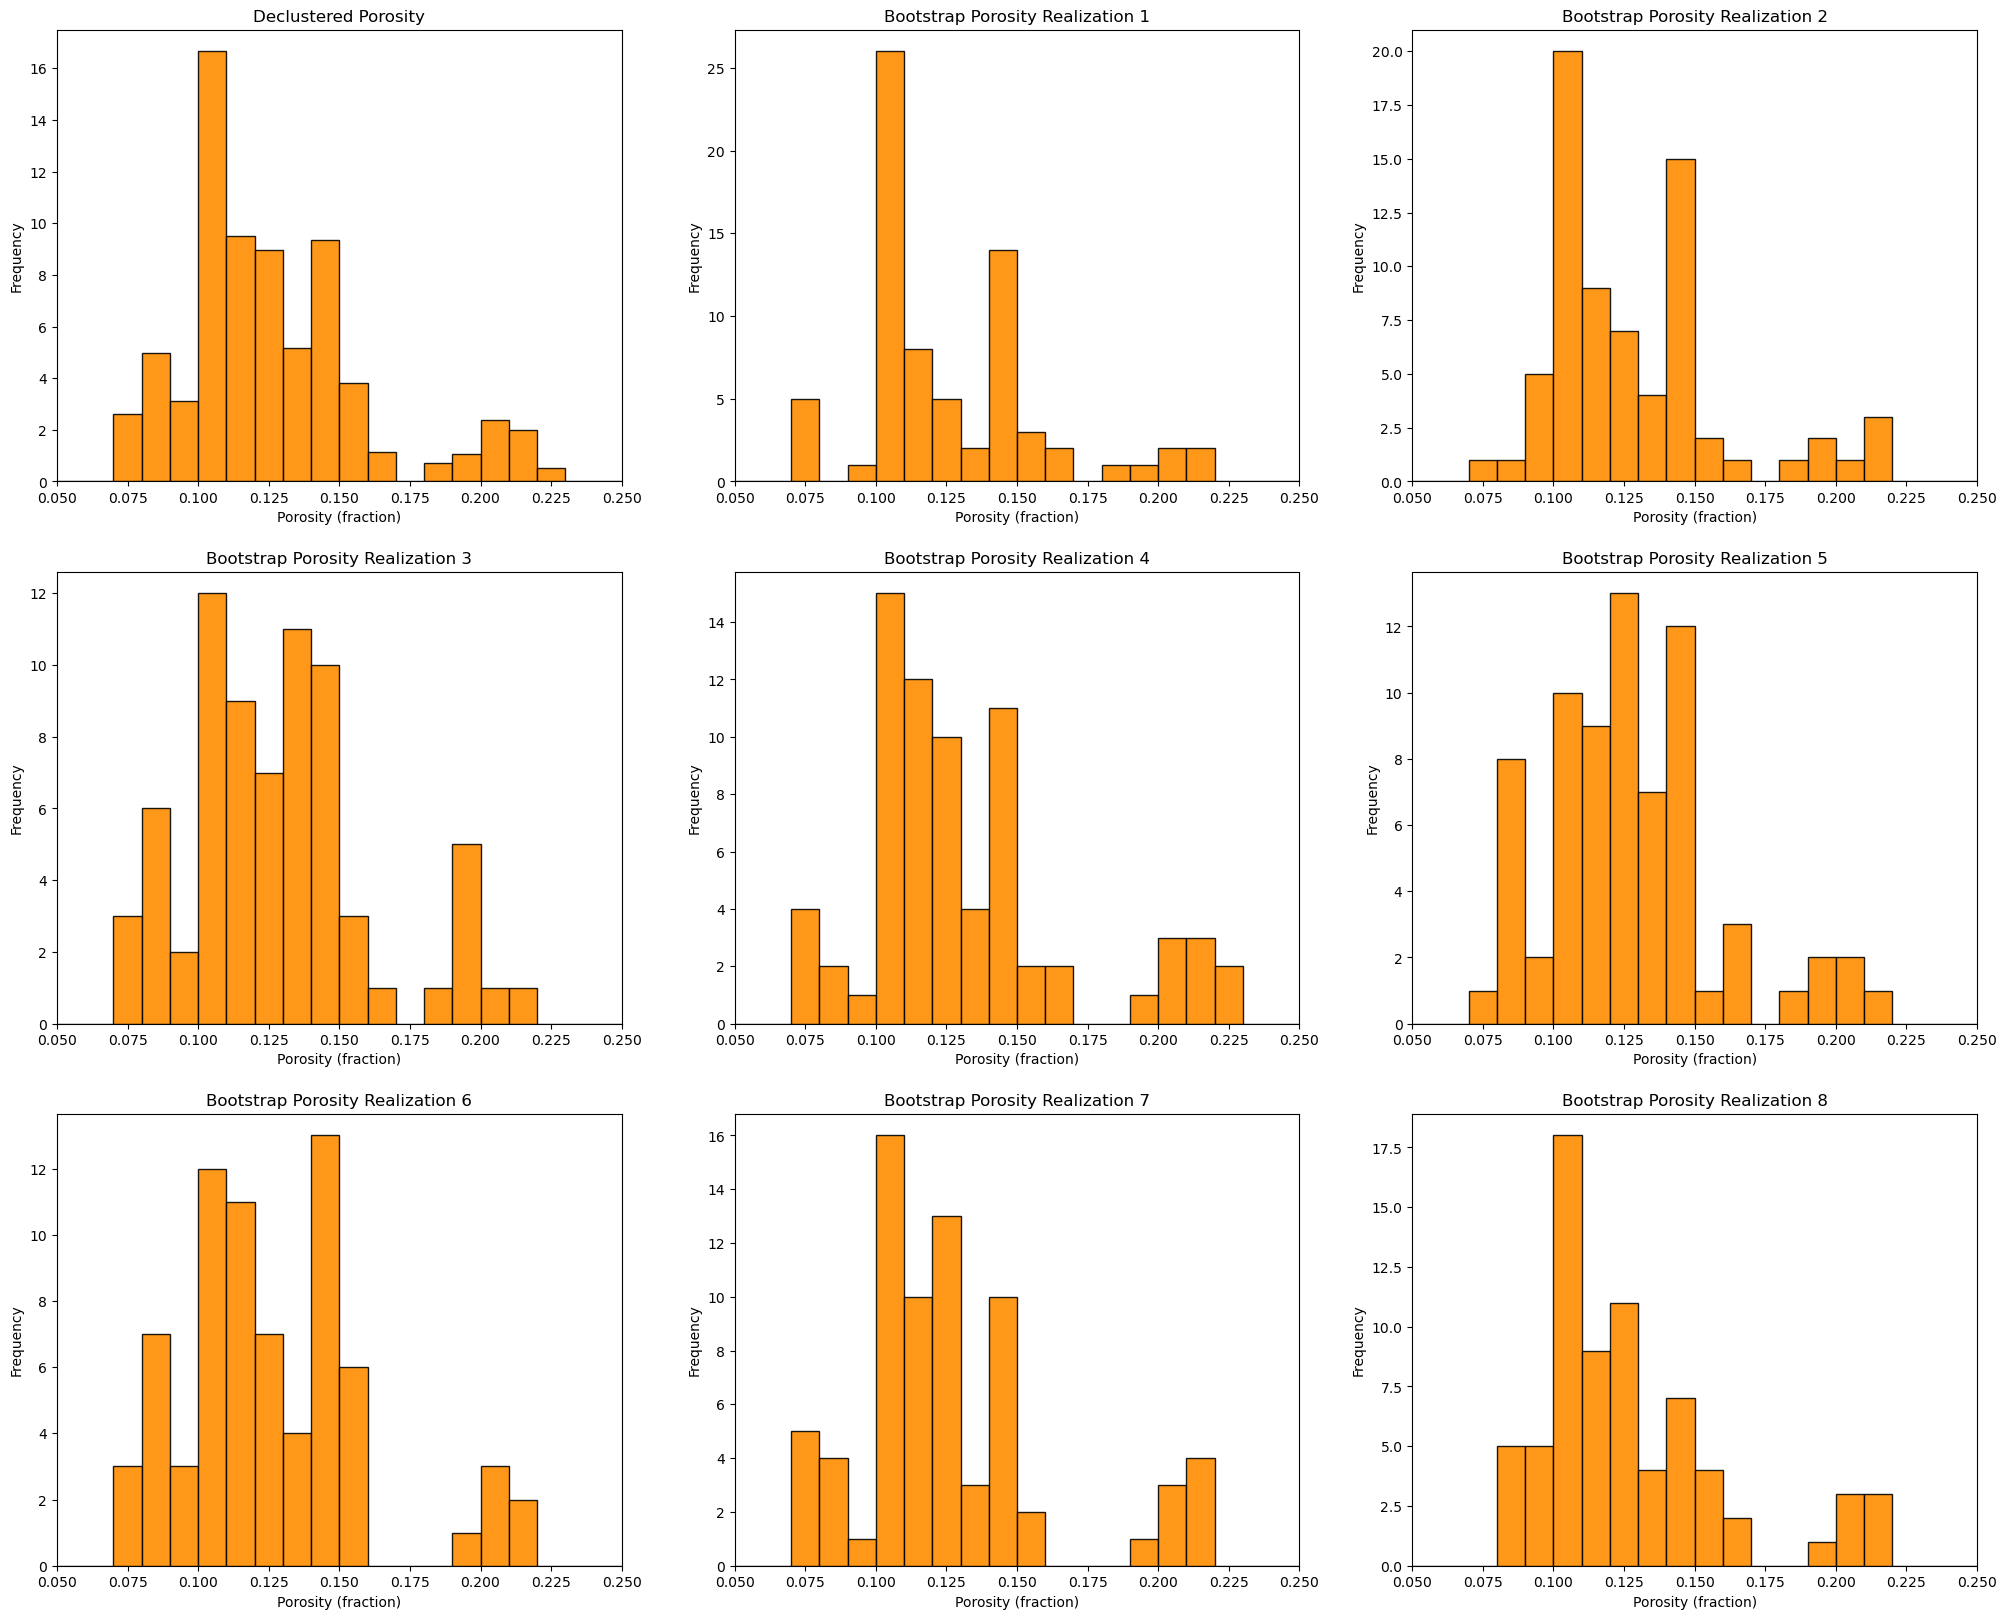

In [12]:
nreal = 200                               # number of bootstrap realizations
nhist = 8                                 # number of bootstrap histograms to view (max 8)                             
samples = np.zeros((nreal,len(df))); real_label = []

for ireal in range(0,nreal):
    samples[ireal] = random.choices(df['Porosity'].values, weights=df['Wts'].values, cum_weights=None, k=len(df))

plt.subplot(3,3,1)
GSLIB.hist_st(df['Porosity'],pormin,pormax,False,False,20,df['Wts'],'Porosity (fraction)','Declustered Porosity')

for ireal in range(0,nhist):
    plt.subplot(3,3,ireal+2)
    GSLIB.hist_st(samples[ireal],pormin,pormax,False,False,20,None,'Porosity (fraction)','Bootstrap Porosity Realization ' + str(ireal+1))

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=3.2, wspace=0.2, hspace=0.2)
plt.show()

#### Distribution Shape

The distribution seems to be bimodel (two peaks).  

* Instead of looking at a few histograms of bootstrap realizations, let's look at many realizations and see if there is always, mostly or just sometimes two modes.

We will visualize many bootstrap realizations of the entire distribution.

This code loops over the realizations and adds each to a probability density plot:

```python
for ireal in range(0,nreal):              
    sns.distplot(samples[ireal])
```

where each bootstrap realization is a row in the 2D ndarray samples.

The additional prameters control the visualization:

```python
color = 'black', hist = False, kde = True,kde_kws = {"alpha": 0.02, 'linewidth': 5}
```
for example: 

* **kde** is a kernel density estimator to conver the data to a smooth density estimate

* **alpha** is the level of transparency

See what you think.  From the image below can you see the uncertainty in the distribution?

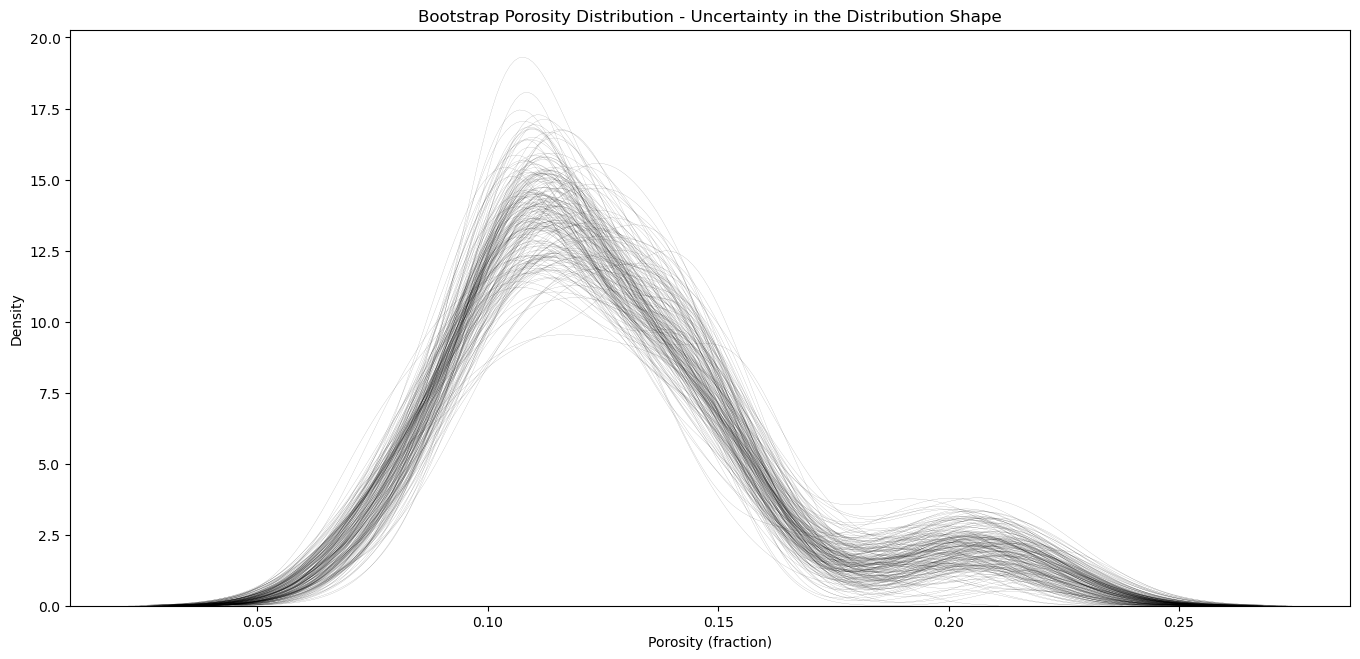

In [13]:
for ireal in range(0,nreal):              # loop over the realizations and plot with seaborn package
    # Draw the density plot
    # sns.distplot(samples[ireal], color = 'black', hist = False, kde = True,kde_kws = {"alpha": 0.002, 'linewidth': 5})
    sns.kdeplot(samples[ireal], color = 'black',alpha=0.6,lw=.1)
plt.title('Bootstrap Porosity Distribution - Uncertainty in the Distribution Shape')
plt.xlabel('Porosity (fraction)')
plt.ylabel('Density')

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2, hspace=0.2)
plt.show()

Note that the bootstrap distributions vary quite a bit from the original, but the bimodal shape is consistent; therefore the bimodal distribution form is **not due to random effect / sparse sampling**! We are likely dealing with two distinct processes and / or spatial trends.

#### Summarizations Over Bootstrap Realizations

Let's make a loop to conduct $L$ resamples and calculate the average and standard deviation for each  ($m^\ell$, $\sigma^2_{\ell}$,  for $\ell = 0,\dots,L-1$). We then summarization over these $L$ realizations.  

I did not find any built-in, concise functions to accomplish this, i.e. with a single line of code, so we are going to do it by hand.  

To understand this code there are just a couple of Python concepts that you need to add to your Python arsenal.

1. declaring arrays - NumPy has a lot of great array (ndarray) functionality. There are build in functions to make a ndarray of any length (and dimension). This includes 'zeros', 'ones' and 'rand', so when we use this code: 

 `mean = np.zeros(L); stdev = np.zeros(L)`

 we're making arrays of length $L$ pre-populated with zeros.

2. For Loops - when we are using the command below, we are instructing the computer to loop over all the indented code below the command for $l = 0,1,2,\ldots,L-1$ times. For each loop the $l$ variable increments, so we can use this to save each result to a different index in the arrays mean and stdev. Note, Python arrays index starting at 0 and stop at the length - 1.

 `for l in range(0, L):` 
 
 we are running each bootstrap resampled realization, calculating the average and standard deviation and storing them in the arrays that we already declared.

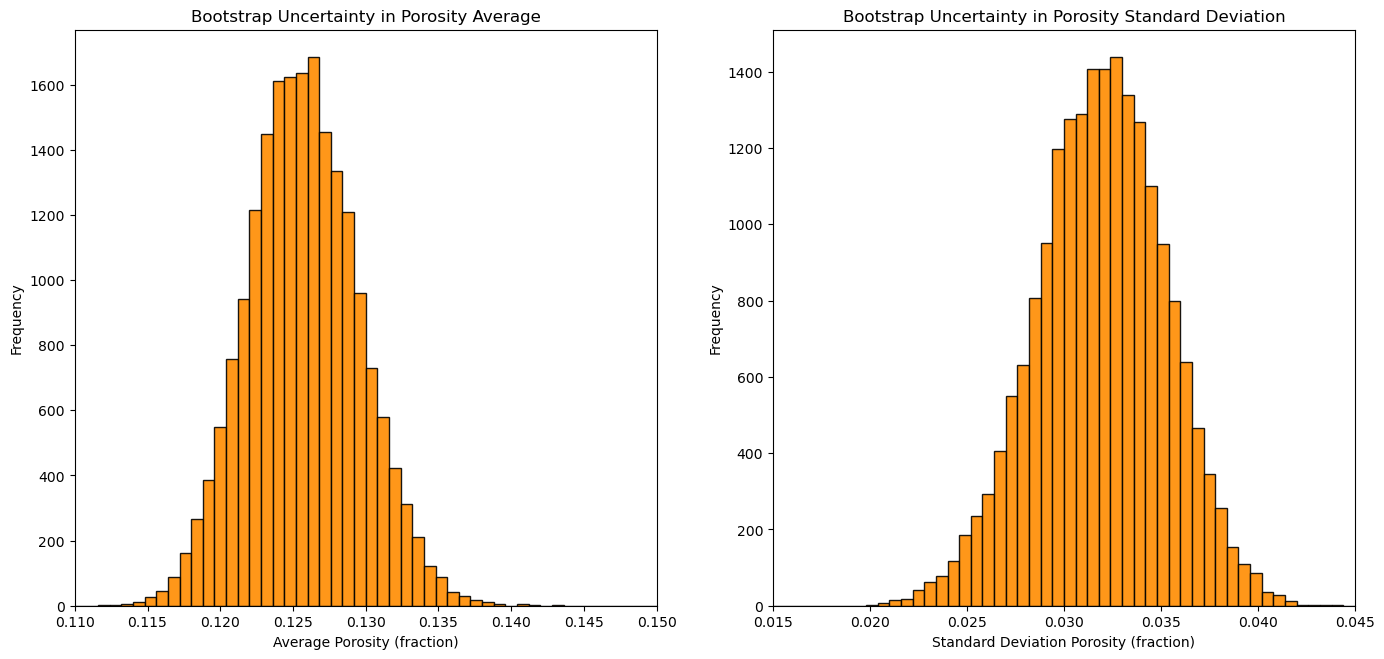

Summary Statistics for Bootstrap Porosity Average:
DescribeResult(nobs=20000, minmax=(0.11163971197222221, 0.1434036251111111), mean=0.12570588953669515, variance=1.4368376144541213e-05, skewness=0.1379592585864566, kurtosis=0.048709286348534775)

Uncertainty in Porosity Average: P10 12.1%, P50 12.6%, P90 13.1%

Summary Statistics for Bootstrap Porosity Standard Deviation:
DescribeResult(nobs=20000, minmax=(0.019874215648891438, 0.04392048875032648), mean=0.03191339381938312, variance=1.104605442467541e-05, skewness=-0.12210559000352145, kurtosis=-0.042617713956313974)

Uncertainty in Porosity Standard Deviation: P10 2.8000000000000003%, P50 3.2%, P90 3.6%


In [14]:
L = 20000                                  # set the number of realizations for uncertainty calculation
mean = np.zeros(L); stdev = np.zeros(L)    # declare arrays to hold the realizations of the statistics
P10 = np.zeros(L)                          
P50 = np.zeros(L); P90 = np.zeros(L)                         
for l in range(0, L):                      # loop over realizations
    samples = random.choices(df['Porosity'].values, weights=df['Wts'].values, cum_weights=None, k=len(df))
    mean[l] = np.average(samples)
    stdev[l] = np.std(samples)
    
plt.subplot(121)
GSLIB.hist_st(mean,0.11,0.15,False,False,50,None,'Average Porosity (fraction)','Bootstrap Uncertainty in Porosity Average')

plt.subplot(122)
GSLIB.hist_st(stdev,0.015,0.045,False,False,50,None,'Standard Deviation Porosity (fraction)','Bootstrap Uncertainty in Porosity Standard Deviation')

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2, hspace=0.2)
plt.show()   
    
print('Summary Statistics for Bootstrap Porosity Average:')
print(stats.describe(mean))
print('\nUncertainty in Porosity Average: P10 ' + str(round(np.percentile(mean,10)*100,1)) + '%, P50 ' + str(round(np.percentile(mean,50)*100,1)) + '%, P90 ' + str(round(np.percentile(mean,90)*100,1)) +"%") 

print('\nSummary Statistics for Bootstrap Porosity Standard Deviation:')
print(stats.describe(stdev)); 
print('\nUncertainty in Porosity Standard Deviation: P10 ' + str(round(np.percentile(stdev,10),3)*100) + '%, P50 ' + str(round(np.percentile(stdev,50),3)*100) + '%, P90 ' + str(round(np.percentile(stdev,90)*100,1)) + "%") 


#### Uncertainty in the Percentiles

We could even calculate the uncertainty in the percentiles, well-based P10, P50 and P90.

* this demonstrates the flexiblity of the bootstrap method

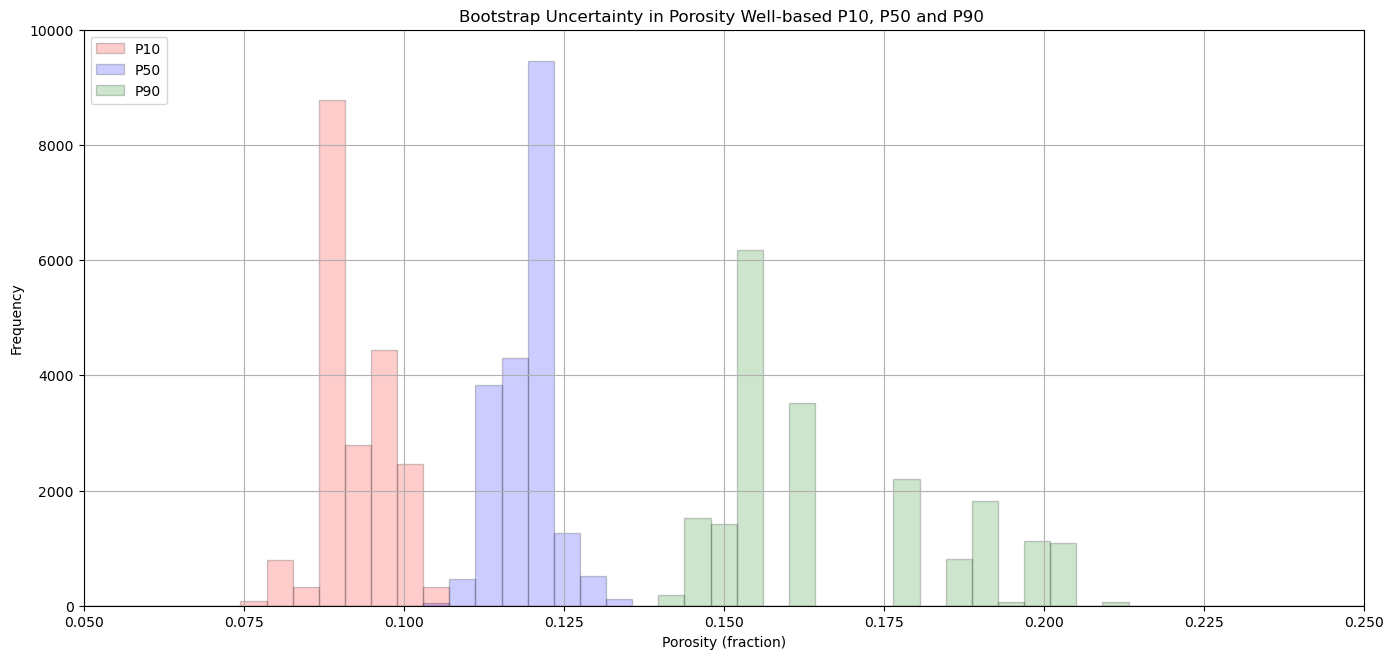

In [15]:
L = 20000                                  # set the number of realizations for uncertainty calculation
mean = np.zeros(L); stdev = np.zeros(L)    # declare arrays to hold the realizations of the statistics
P10 = np.zeros(L)                          
P50 = np.zeros(L); P90 = np.zeros(L)                         
for l in range(0, L):                      # loop over realizations
    samples = random.choices(df['Porosity'].values, weights=df['Wts'].values, cum_weights=None, k=len(df))
    P10[l] = np.percentile(q = 10, a = samples)
    P50[l] = np.percentile(q = 50, a = samples)
    P90[l] = np.percentile(q = 90, a = samples)

plt.subplot(111)
plt.hist(P10, facecolor='red',bins=np.linspace(0.05,0.25,50),alpha=0.2,density=False,edgecolor='black',label='P10')
plt.hist(P50, facecolor='blue',bins=np.linspace(0.05,0.25,50),alpha=0.2,density=False,edgecolor='black',label = 'P50')
plt.hist(P90, facecolor='green',bins=np.linspace(0.05,0.25,50),alpha=0.2,density=False,edgecolor='black',label = 'P90')
plt.xlim([0.05,0.25]); plt.ylim([0,10000.0])
plt.xlabel('Porosity (fraction)'); plt.ylabel('Frequency'); plt.title('Bootstrap Uncertainty in Porosity Well-based P10, P50 and P90 ')
plt.legend(loc='upper left')
plt.grid(True)
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2, hspace=0.2)
plt.show()

#### Comments

This was a basic demonstration of bootstrap. Much more could be done, you could replace the statistics, average and standard deviation with any other statistics, for example P90, kurtosis, P13 etc. I have other demonstrations on the basics of working with DataFrames, ndarrays, univariate statistics, plotting data, declustering, data transformations, trend modeling and many other workflows available at https://github.com/GeostatsGuy/PythonNumericalDemos and https://github.com/GeostatsGuy/GeostatsPy. 

<i>&copy; Copyright daytum 2025. All Rights Reserved</i>